# Домашнє завдання: ETL-пайплайни для аналітиків даних

Це ДЗ передбачене під виконання на локальній машині. Виконання з Google Colab буде суттєво ускладнене.

## Підготовка
1. Переконайтесь, що у вас встановлены необхідні бібліотеки:
   ```bash
   pip install sqlalchemy pymysql pandas matplotlib seaborn python-dotenv
   ```

2. Створіть файл `.env` з параметрами підключення до бази даних classicmodels. Базу даних ви можете отримати через

  - docker-контейнер згідно існтрукції в [документі](https://www.notion.so/hannapylieva/Docker-1eb94835849480c9b2e7f5dc22ee4df9), також відео інструкції присутні на платформі - уроки "MySQL бази, клієнт для роботи з БД, Docker і ChatGPT для запитів" та "Як встановити Docker для роботи з базами даних без терміналу"
  - або встановивши локально цю БД - для цього перегляньте урок "Опціонально. Встановлення MySQL та  БД Сlassicmodels локально".
  
  Приклад `.env` файлу ми створювали в лекції. Ось його обовʼязкове наповнення:
    ```
    DB_HOST=your_host
    DB_PORT=3306 або 3307 - той, який Ви налаштували
    DB_USER=your_username
    DB_PASSWORD=your_password
    DB_NAME=classicmodels
    ```
  Якщо ви створили цей файл під час перегляду лекції - **новий створювати не треба**. Замініть лише назву БД, або пропишіть назву в коді створення підключення (замість отримання назви цільової БД зі змінних оточення). Але переконайтесь, що до `.env` файл лежить в тій самій папці, що і цей ноутбук.

  **УВАГА!** НЕ копіюйте скрит для **створення** `.env` файлу. В лекції він наводиться для прикладу. І давалось пояснення, що в реальних проєктах ми НІКОЛИ не пишемо доступи до бази в коді. Копіювання скрипта для створення `.env` файлу сюди в ДЗ буде вважатись грубою помилкою і ми зніматимемо бали.

3. Налаштуйте підключення через SQLAlchemy до БД за прикладом в лекції.

Рекомендую вивести (відобразити) змінну engine після створення. Вона має бути не None! Якщо None - значить у Вас не підтягнулись налаштування з .env файла.

Ви також можете налаштувати параметри підключення до БД без .env файла, просто прописавши текстом в відповідних місцях. Це - не рекомендований підхід.

### Завдання 1: Створення таблиці курсів валют та API інтеграція (2 бали)

**Повторіть процедуру з лекції:** створіть таблицю для курсів валют, але вже в цій базі даних. Результатом має бути нова таблиця з курсами валют USD, EUR, UAH в БД (можна завантажити більше валют). Продемонструйте, що таблиця була додана, використовуючи SELECT.

Тобто тут ви можете прямо скопіювати код з лекції, внести необхідні зміни і запустити. Головне - отримати таблицю в БД classicmodels.

In [8]:
# Створюємо таблицю для курсів валют (сучасний спосіб)
def create_currency_table(engine):
    """Створює таблицю через SQLAlchemy"""

    create_table_sql = text("""
    CREATE TABLE IF NOT EXISTS currency_rates (
        id INT AUTO_INCREMENT PRIMARY KEY,
        currency_code VARCHAR(3) NOT NULL,
        rate_to_usd DECIMAL(10, 6) NOT NULL,
        rate_date DATE NOT NULL,
        created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
        updated_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP ON UPDATE CURRENT_TIMESTAMP,
        INDEX idx_currency_date (currency_code, rate_date),
        UNIQUE KEY unique_currency_date (currency_code, rate_date)
    )
    """)

    with engine.connect() as conn:
        # тут лише одна транзакція - conn.begin() не треба
        conn.execute(create_table_sql)

    print("✅ Таблиця currency_rates створена")

def fetch_exchange_rates():
    """Отримує курси валют з API"""
    try:
        # Безкоштовний API курсів валют
        url = "https://api.exchangerate-api.com/v4/latest/USD"
        response = requests.get(url, timeout=10)
        response.raise_for_status()

        data = response.json()

        # Валюти що нас цікавлять
        currencies = ['EUR', 'GBP', 'UAH', 'PLN', 'JPY', 'CZK', 'INR', 'AED', 'QAR']
        rates = {}

        for currency in currencies:
            if currency in data['rates']:
                # Зберігаємо курс до USD (скільки одиниць валюти за 1 USD)
                rates[currency] = data['rates'][currency]

        return rates, datetime.date.today()

    except Exception as e:
        print(f"❌ Помилка API: {e}")
        return None, None

def save_exchange_rates(engine, rates_dict, rate_date):
    """Зберігає курси в БД з обробкою конфліктів"""

    if not rates_dict:
        print("❌ Немає даних для збереження")
        return False

    # SQL з ON DUPLICATE KEY UPDATE для MySQL
    insert_sql = text("""
    INSERT INTO currency_rates (currency_code, rate_to_usd, rate_date)
    VALUES (:currency, :rate, :date)
    ON DUPLICATE KEY UPDATE
        rate_to_usd = VALUES(rate_to_usd),
        updated_at = CURRENT_TIMESTAMP
    """)

    try:
        with engine.connect() as conn:
            with conn.begin():  # Транзакція для всіх вставок
                for currency, rate in rates_dict.items():
                    conn.execute(insert_sql, {
                        'currency': currency,
                        'rate': rate,
                        'date': rate_date
                    })

        print(f"✅ Збережено {len(rates_dict)} курсів валют на {rate_date}")
        return True

    except Exception as e:
        print(f"❌ Помилка збереження: {e}")
        return False

In [9]:
# Виконуємо повний цикл API → БД
create_currency_table(engine)

print("📡 Отримуємо курси валют...")
rates, date = fetch_exchange_rates()

if rates:
    print(f"Отримані курси на {date}:")
    for currency, rate in rates.items():
        print(f"  1 USD = {rate:.4f} {currency}")

    # Зберігаємо в БД
    if save_exchange_rates(engine, rates, date):
        # Перевіряємо збережені дані
        verification_df = pd.read_sql(
            "SELECT * FROM currency_rates ORDER BY created_at DESC LIMIT 10",
            engine
        )
        print("\nЗбережені дані:")
        display(verification_df)

✅ Таблиця currency_rates створена
📡 Отримуємо курси валют...
Отримані курси на 2025-12-20:
  1 USD = 0.8530 EUR
  1 USD = 0.7480 GBP
  1 USD = 42.2700 UAH
  1 USD = 3.5900 PLN
  1 USD = 157.3300 JPY
  1 USD = 20.7800 CZK
  1 USD = 89.9000 INR
  1 USD = 3.6700 AED
  1 USD = 3.6400 QAR
✅ Збережено 9 курсів валют на 2025-12-20

Збережені дані:


,id,currency_code,rate_to_usd,rate_date,created_at,updated_at
0,1,EUR,0.853,2025-12-20,2025-12-20 15:10:31,2025-12-20 15:10:31
1,2,GBP,0.748,2025-12-20,2025-12-20 15:10:31,2025-12-20 15:10:31
2,3,UAH,42.270,2025-12-20,2025-12-20 15:10:31,2025-12-20 15:10:31
3,4,PLN,3.590,2025-12-20,2025-12-20 15:10:31,2025-12-20 15:10:31
4,5,JPY,157.330,2025-12-20,2025-12-20 15:10:31,2025-12-20 15:10:31
5,6,CZK,20.780,2025-12-20,2025-12-20 15:10:31,2025-12-20 15:10:31
6,7,INR,89.900,2025-12-20,2025-12-20 15:10:31,2025-12-20 15:10:31
7,8,AED,3.670,2025-12-20,2025-12-20 15:10:31,2025-12-20 15:10:31
8,9,QAR,3.640,2025-12-20,2025-12-20 15:10:31,2025-12-20 15:10:31


# Завдання 2: Створення простого ETL пайплайну (7 балів)

В цьому завданні ми створимо повноцінний ETL процес для аналізу продажів ClassicModels.

Завдання обʼємне і оцінюється відповідно. Ви можете пропустити обчислення якихось з метрик, якщо відчуєте, що вже немає сил робити це завдання. Бал буде виставлено виходячи з виконаного обʼєму та його правильності.

## Що саме треба зробити:

### Extract (Витягування даних):
На цьому етапі треба витягнути дані з БД в pandas.DataFrame для подальшої обробки.
Які дані нам потрібні (кожен пункт - в окремий фрейм даних):
1. **дані про виконані замовлення за 2004 рік** - з'єднати таблиці orders, orderdetails, products, customers
2. **дані про продукти** - назви, категорії, ціни
3. **дані про курси валют** - використати дані з попереднього завдання

### Transform (Обробка даних):

#### 2.1 Додати розрахункові колонки до основної таблиці:
Додайте до DataFrame з продажами такі нові колонки:

- **`profit_per_item`** - прибуток з одного товару (використайте колонки: `priceEach` - `buyPrice`)
- **`total_profit`** - загальний прибуток з товарної позиції (використайте колонки: `profit_per_item` × `quantityOrdered`)
- **`total_amount_eur`** - сума в євро (використайте колонки: `total_amount` / `eur_rate`)

#### 2.2 Створити аналітичну таблицю по країнах (ТОП-5):
Згрупуйте дані по колонці **`country`** та обчисліть для кожної країни:

**Метрики для розрахунку:**
- **Кількість унікальних замовлень** - унікальні значення колонки `orderNumber`
- **Загальний дохід** - сума колонки `total_amount`
- **Загальний прибуток** - сума колонки `total_profit`
- **Кількість проданих товарів** - сума колонки `quantityOrdered`
- **Маржа прибутку (%)** - (`загальний прибуток` / `загальний дохід`) × 100

**Результат:** Таблиця з 5 найприбутковіших країн, відсортована за загальним доходом (від більшого до меншого).

#### 2.3 Створити аналітичну таблицю по продуктових лініях:
Згрупуйте дані по колонці **`productLine`** та обчисліть ті ж метрики:

**Метрики для розрахунку:**
- **Кількість унікальних замовлень** - унікальні значення колонки `orderNumber`
- **Загальний дохід** - сума колонки `total_amount`
- **Загальний прибуток** - сума колонки `total_profit`
- **Кількість проданих товарів** - сума колонки `quantityOrdered`
- **Маржа прибутку (%)** - (`загальний прибуток` / `загальний дохід`) × 100

**Результат:** Таблиця з усіма продуктовими лініями, відсортована за загальним доходом.

#### 2.4 Створити підсумкову інформацію (Executive Summary):
Розрахуйте загальні показники бізнесу за 2004 рік:

**Фінансові показники:**
- **Загальний дохід в доларах** - сума всієї колонки `total_amount`
- **Загальний дохід в євро** - сума всієї колонки `total_amount_eur`
- **Загальний прибуток в доларах** - сума всієї колонки `total_profit`
- **Загальна маржа прибутку (%)** - (`загальний прибуток` / `загальний дохід`) × 100
- **Середній розмір замовлення** - середнє значення колонки `total_amount`

**Операційні показники:**
- **Кількість унікальних замовлень** - унікальні значення колонки `orderNumber`
- **Кількість унікальних клієнтів** - унікальні значення колонки `customerName`
- **Період даних** - мінімальна та максимальна дата з колонки `orderDate`

**Топ показники:**
- **Найприбутковіша країна** - перший рядок з таблиці країн (колонка `country`)
- **Найприбутковіша продуктова лінія** - перший рядок з таблиці продуктів (колонка `productLine`)

### Load (Збереження результатів):
В цій частині ми зберігаємо результати наших обчислень.
Використайте приклади коду з лекцій та адаптуйте його під цей ETL процес.
Що Вам потрібно створити:

#### 3.1 Excel файл з трьома вкладками:
- **"Summary"** - підсумкова інформація у вигляді таблиці "Показник - Значення"
- **"Top_Countries"** - аналітика по топ-5 країнах
- **"Product_Lines"** - аналітика по всіх продуктових лініях

#### 3.2 Візуалізація:
- Створіть стовпчикову діаграму топ-5 країн за доходом.
- Створіть pie chart з відсотковим розподілом доходу в USD по продуктових лінійках.

## РЕКОМЕНДАЦІЇ ДО ВИКОНАННЯ:

### Покрокова стратегія виконання:
1. Спочатку протестуйте Extract просто в Jupyter notebook (без фукнції) - переконайтеся що SQL запит працює і повертає дані за 2004 рік
2. Потім протестуйте кожен Transform окремо - виведіть проміжні результати
3. Нарешті протестуйте Load - перевірте що файли створюються правильно  
4. Тільки після цього обгортайте все в функцію

### Як перевірити що все працює:
- Виводьте на екран, який етап зараз відбувається
- Виведіть кількість записів після кожного кроку
- Покажіть перші 5 рядків кожної аналітичної таблиці
- Перевірте що дати належать 2004 року
- Переконайтеся що маржа прибутку в розумних межах (0-50%)

In [45]:
# Data for 2004:
query_sales = text("""
    SELECT 
        o.orderNumber, o.orderDate,c.customerName, c.country,p.productName, p.productLine, p.buyPrice,
        od.quantityOrdered, od.priceEach,(od.quantityOrdered * od.priceEach) as Total_Amount
    FROM orders o
    JOIN customers c ON o.customerNumber = c.customerNumber
    JOIN orderdetails od ON o.orderNumber = od.orderNumber
    JOIN products p ON od.productCode = p.productCode
    WHERE o.orderDate BETWEEN '2004-01-01' AND '2004-12-31'AND o.status NOT IN ('On Hold', 'Disputed')""")

df_sales = pd.read_sql(query_sales, engine)

df_currencies = pd.read_sql(text("SELECT * FROM currency_rates WHERE currency_code = 'EUR'"), engine)
eur_rate = df_currencies['rate_to_usd'].iloc[0]
print(f"EUR rate is: {eur_rate}")


print(f"Records: {len(df_sales)}")
print(f"Date Range: {df_sales['orderDate'].min()} - {df_sales['orderDate'].max()}")
print("First 5 rows of orders:")
display(df_sales.head())


EUR rate is: 0.853
Records: 1415
Date Range: 2004-01-02 - 2004-12-17
First 5 rows of orders:


,orderNumber,orderDate,customerName,country,productName,productLine,buyPrice,quantityOrdered,priceEach,Total_Amount
0,10208,2004-01-02,"Saveley & Henriot, Co.",France,2001 Ferrari Enzo,Classic Cars,95.59,46,176.63,8124.98
1,10208,2004-01-02,"Saveley & Henriot, Co.",France,1969 Corvair Monza,Classic Cars,89.14,26,128.42,3338.92
2,10208,2004-01-02,"Saveley & Henriot, Co.",France,1969 Ford Falcon,Classic Cars,83.05,20,152.26,3045.20
3,10208,2004-01-02,"Saveley & Henriot, Co.",France,1903 Ford Model A,Vintage Cars,68.30,24,117.47,2819.28
4,10208,2004-01-02,"Saveley & Henriot, Co.",France,Collectable Wooden Train,Trains,67.56,48,96.81,4646.88


In [46]:
# Transforming data
df_sales['profit_per_item'] = df_sales['priceEach'] - df_sales['buyPrice']
df_sales['total_profit'] = df_sales['profit_per_item'] * df_sales['quantityOrdered']
df_sales['total_amount_eur'] = df_sales['Total_Amount'] * eur_rate

In [48]:
# Countries (Top-5):
df_countries = df_sales.groupby('country').agg(
    unique_orders=('orderNumber', 'nunique'),
    total_revenue=('Total_Amount', 'sum'),
    total_profit=('total_profit', 'sum'),
    total_quantity=('quantityOrdered', 'sum'))

df_countries['profit_margin_pct'] = (df_countries['total_profit'] / df_countries['total_revenue']) * 100
df_top_countries = df_countries.sort_values('total_revenue', ascending=False).head(5)
display(df_top_countries)

,unique_orders,total_revenue,total_profit,total_quantity,profit_margin_pct
country,,,,,
USA,53,1526499.65,614370.08,16719,40.246985
France,19,506660.01,211528.15,5632,41.749525
Spain,14,439881.84,175328.56,4962,39.858104
UK,7,238193.93,93425.03,2778,39.222255
New Zealand,6,233362.27,94390.14,2537,40.447901


In [49]:
# Product line:
df_lines = df_sales.groupby('productLine').agg(
    unique_orders=('orderNumber', 'nunique'),
    total_revenue=('Total_Amount', 'sum'),
    total_profit=('total_profit', 'sum'),
    total_quantity=('quantityOrdered', 'sum'))

df_lines['profit_margin_pct'] = (df_lines['total_profit'] / df_lines['total_revenue']) * 100
df_lines = df_lines.sort_values('total_revenue', ascending=False)
display(df_lines)

,unique_orders,total_revenue,total_profit,total_quantity,profit_margin_pct
productLine,,,,,
Classic Cars,96,1756809.87,701757.35,16039,39.944980
Vintage Cars,88,854551.85,350298.70,10864,40.992094
Motorcycles,37,527243.84,222485.41,5976,42.197821
Planes,34,471971.46,182273.04,5820,38.619505
Trucks and Buses,39,448702.69,176415.25,4853,39.316736
Ships,35,337326.10,134731.87,4309,39.941134
Trains,22,96285.53,33672.63,1409,34.971641


In [54]:
def create_report(df, groupby_column):
    report = df.groupby(groupby_column).agg(
        unique_orders=('orderNumber', 'nunique'),
        total_revenue=('Total_Amount', 'sum'),
        total_profit=('total_profit', 'sum'),
        total_quantity=('quantityOrdered', 'sum'))
    
    report['profit_margin_pct'] = (report['total_profit'] / report['total_revenue']) * 100
    return report.sort_values(by='total_revenue', ascending=False)

df_top_countries = create_report(df_sales, 'country').head(5)
df_product_lines = create_report(df_sales, 'productLine')

In [55]:
# Executive summary:
executive_summary_data = {
    "Metric":["Revenue USD", "Revenue EUR", "Profit USD", "Avg Margin %", "Avg Order Value","Orders", "Customers", 
              "Data Start","Data End","Top Country", "Top Product Line"],
    "Value": [
        df_sales['Total_Amount'].sum(),
        df_sales['total_amount_eur'].sum(),
        df_sales['total_profit'].sum(),
        (df_sales['total_profit'].sum() / df_sales['Total_Amount'].sum()) * 100,
        df_sales.groupby('orderNumber')['Total_Amount'].sum().mean(),
        df_sales['orderNumber'].nunique(),
        df_sales['customerName'].nunique(),
        df_sales['orderDate'].min(),
        df_sales['orderDate'].max(),
        df_top_countries.index[0],
        df_product_lines.index[0]]}

df_summary = pd.DataFrame(executive_summary_data)
display(df_summary)

,Metric,Value
0,Revenue USD,4492891.34
1,Revenue EUR,3832436.31302
2,Profit USD,1801634.25
3,Avg Margin %,40.099662
4,Avg Order Value,29952.608933
5,Orders,150
6,Customers,89
7,Data Start,2004-01-02
8,Data End,2004-12-17
9,Top Country,USA


In [56]:
print(df_top_countries[['total_revenue', 'profit_margin_pct']])
print(f"Min: {df_lines['profit_margin_pct'].min():.0f}%, Max: {df_lines['profit_margin_pct'].max():.0f}%")

             total_revenue  profit_margin_pct
country                                      
USA             1526499.65          40.246985
France           506660.01          41.749525
Spain            439881.84          39.858104
UK               238193.93          39.222255
New Zealand      233362.27          40.447901
Min: 35%, Max: 42%


In [61]:
!python3 -m pip install xlsxwriter


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


In [62]:
file_name = "Report_ClassicModels_Year_2004.xlsx"
with pd.ExcelWriter(file_name, engine='xlsxwriter') as writer:
    df_summary.to_excel(writer, sheet_name='Summary', index=False)
    df_top_countries.to_excel(writer, sheet_name='Top_Countries')
    df_lines.to_excel(writer, sheet_name='Product_Lines')

print(f"File'{file_name}'created!")

File'Report_ClassicModels_Year_2004.xlsx'created!


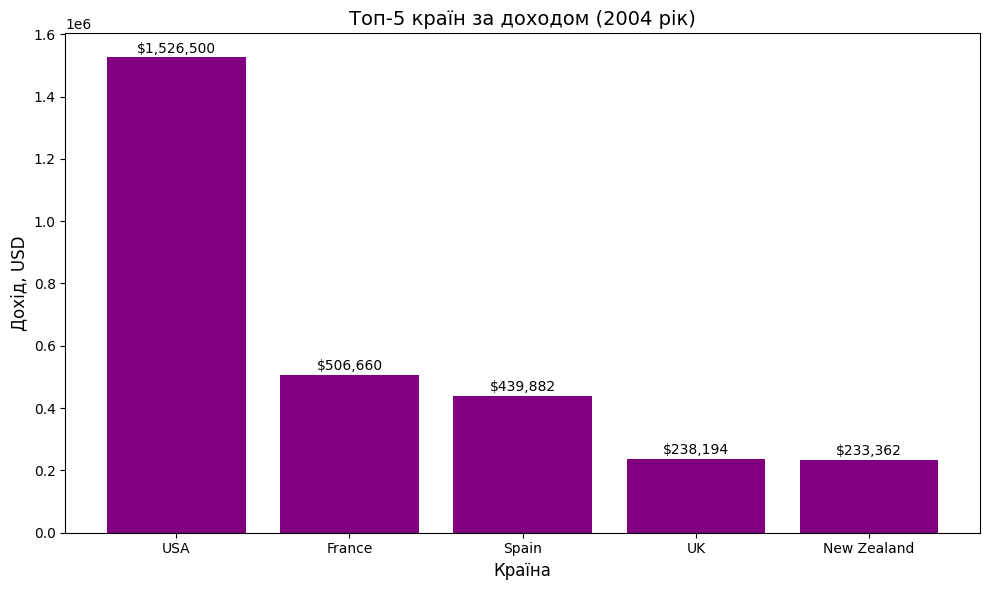

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

bars = plt.bar(df_top_countries.index, df_top_countries['total_revenue'], color='purple')

plt.title('Топ-5 країн за доходом (2004 рік)', fontsize=14)
plt.xlabel('Країна', fontsize=12)
plt.ylabel('Дохід, USD', fontsize=12)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5000, f'${yval:,.0f}', ha='center', va='bottom')


plt.tight_layout()
plt.show();

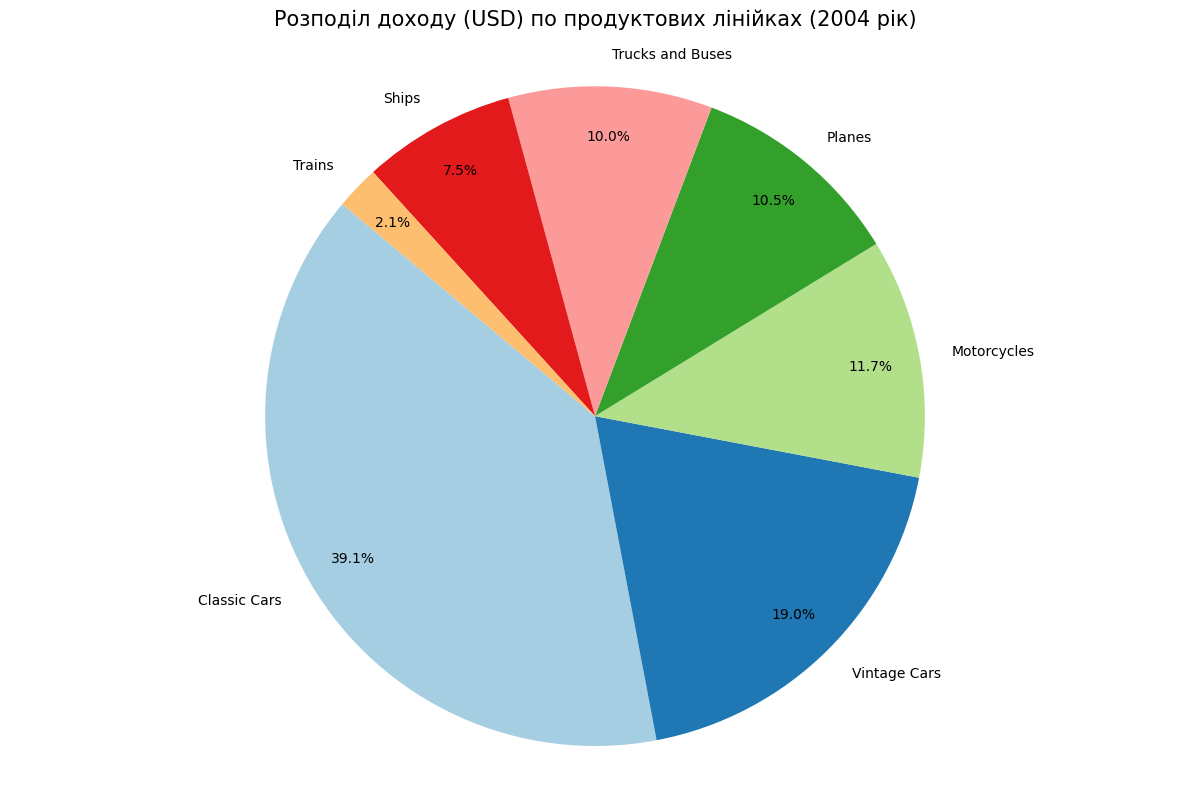

In [66]:
plt.figure(figsize=(12, 8))

plt.pie(
    df_lines['total_revenue'], 
    labels=df_lines.index, 
    autopct='%1.1f%%',      
    startangle=140,         
    colors=plt.cm.Paired.colors,
    pctdistance=0.85)

plt.title('Розподіл доходу (USD) по продуктових лінійках (2004 рік)', fontsize=15, pad=20)

plt.axis('equal') 

plt.tight_layout()
plt.show();